# Production Model and Conclusion

---

## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to remove
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
def qual_to_num(data, feature):
    '''
    Takes in DataFrame and column name containing string ratings
    replaces the ratings with numerical values
    
    Returns the updated DataFrame
    '''
    
    # ratings that appear in the dataset
    # and corresponding numerical value
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    # convert to ratings using dictionary
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data



def vif_df(df):
    '''
    Takes in a dataframe of numeric columns and computes
    the Variance Inflation Factor (VIF) for each variable.
    
    Returns a nx1 DataFrame of VIF scores.
    '''
    
    corr_features = df.columns
    
    # creats a list of VIF values, cycling through variables
    # to select as a target for scoring
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    # index scores with column names and sort from greatest to least
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif



def setup_test():
    '''
    Generates a cleaned and feature engineered test dataset
    that matches the general structure of the cleaned train data.
    
    Returns the cleaned, feature engineered test data set.
    '''
    
    test_data = pd.read_csv('../datasets/test.csv')
    
    # initial features that were selected for the train dataset 
    test_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type',]
    
    
    test_data = test_data[test_features]
    
    # clean column names
    test_data.columns = [col.lower().replace(' ','_').replace('/','_') for col in test_data.columns]
    
    
    # converts descriptive rating to numerical
    test_data = qual_to_num(test_data, 'bsmt_qual')
    test_data = qual_to_num(test_data, 'bsmt_cond')
    test_data = qual_to_num(test_data, 'kitchen_qual')
    test_data = qual_to_num(test_data, 'exter_qual')
    test_data = qual_to_num(test_data, 'exter_cond')
    test_data = qual_to_num(test_data, 'fireplace_qu')
    
    # combines basment quality and condition ratings via multiplication
    test_data['bsmt_qual_cond'] = test_data['bsmt_qual'] * test_data['bsmt_cond']
    test_data.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)
    
    test_data['qual_cond'] = test_data['overall_qual'] * test_data['overall_cond']
    test_data.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

    test_data['exter_qual_cond'] = test_data['exter_qual'] * test_data['exter_cond']
    test_data.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

    
    # combines fireplace count and quality rating via multiplication
    test_data['fireplaces_weighted'] = test_data['fireplaces'] * test_data['fireplace_qu']
    test_data.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)
    
    # adds square feet (SF) measurements with weights:
    # 1*(Finished SF) + 0.5(Unfinished SF)
    test_data['bsmt_weighted_sf'] = test_data['bsmtfin_sf_1'] + 0.5*test_data['bsmt_unf_sf']
    test_data.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)
    
    # combines full bath and half bath into one column
    test_data['bath'] = test_data['full_bath'] + 0.5*test_data['half_bath']
    test_data.drop(columns = ['full_bath', 'half_bath'], inplace = True)
    
    #combines 1st floor and 2nd floor square feet areas
    test_data['sq_ft'] = test_data['1st_flr_sf'] + test_data['2nd_flr_sf']
    test_data.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)
    
    # replace np.nan with most frequent value in the column 'None'
    test_data.loc[test_data['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'
    
    return test_data


def dummify_train_test(train, numeric_cols, categ_cols):
    '''
    Takes a DataFrame with the desired features to model with,
    sets up a DataFrame of the test dataset with the same features,
    get_dummies is performed on both DataFrames, and then makes sure
    columns agree. If not, columns of zeros are added.
    
    Returns train and test DataFrames with desired features and
    categorical columns dummified and in identical order.
    '''
    
    # generate cleaned and feature engineered test dataframe
    test = setup_test()
    features = numeric_cols + categ_cols
    
    train_with_dummies = pd.get_dummies(train[features], columns = categ_cols, drop_first = True)
    test_with_dummies = pd.get_dummies(test[features], columns = categ_cols, drop_first = True)
    
    # save dummy column names from both train and test
    # to make sure both sets have identical column names/counts later
    both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

    # for any column names not in set, add column with 0s
    for col in both_columns_set:
        if col not in train_with_dummies.columns:
            train_with_dummies[col] = 0
        if col not in test_with_dummies.columns:
            test_with_dummies[col] = 0
            
    # make sure column order agrees for train and test sets
    column_order = train_with_dummies.columns
    test_with_dummies = test_with_dummies[column_order]
    
    return train_with_dummies, test_with_dummies

## Production Model Choice

#### Building the Model

For our production build, we create a mix of models 3 and 4. For this model we use all of the same features as model 4 except we drop the `year_built` feature. This makes our numeric features identical to model 3.

This adjustment is because the VIF scores from the numeric features in model 4 are too high which indicates there is multicollinearity between the variables used. This takes away from the interpretability of our model a bit. Although interpretability of our model is not one of our original goals, it is a worthwhile gain if it only costs a small amount of prediction cabilitiy.

In [3]:
house = pd.read_csv('../datasets/cleaned_train.csv')

In [4]:
# VIFs for model 4
vif_df(house[['sq_ft', 'garage_area', 'bsmt_weighted_sf', 'year_built']])

,vif
sq_ft,14.167112
year_built,12.161775
garage_area,8.755858
bsmt_weighted_sf,5.874826


In [5]:
# VIFs for model 3
vif_df(house[['sq_ft', 'garage_area', 'bsmt_weighted_sf']])

,vif
garage_area,8.520796
sq_ft,8.348290
bsmt_weighted_sf,5.606644


In [6]:
y = house['saleprice']

In [7]:
# select features
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual', 'qual_cond', 'exter_qual_cond']
features = numeric_features + categ_features

In [8]:
# get dummies on train and test datasets
# and make columns agree for modeling
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [9]:
# split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [10]:
# fit a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# generate prediction sale prices on our train (yt_pred) and validation (yv_pred)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [11]:
# print scores for our train split
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

# print scores for our validation split
print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.884804311034452

Train R squared: 0.9097520235829805
Train RMSE: 23989.89319405014

Validation R squared: 0.8798798237233209
Validation RMSE: 26280.68667675776


#### Justifying This Choice

We see a decent improvement in our R squared scores and our RMSE scores are lower compared to our first three linear models. Unlike our model 4, this model is not nearly as overfit.

When we applied Ridge and Lasso models to the nearly the same features as the ones used here, our performance was slightly better. But because we did not have to scale our data to fit this model, we kept the interpretability of our coefficients. This is not the case for Ridge and Lasso. With the scores between the three models being so close, it makes the most sense to stick with our best non regularized linear regression model.

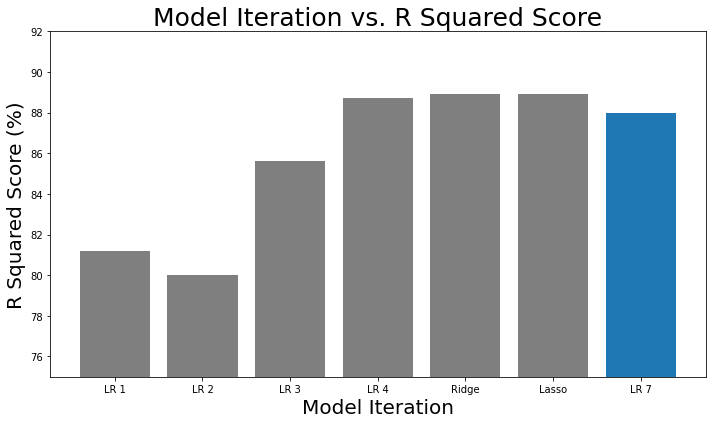

In [12]:
plt.figure(figsize = (10,6))

plt.title('Model Iteration vs. R Squared Score', size = 25)

plt.bar([1,2,3,4,5,6], [81.2, 80, 85.6, 88.7, 88.9, 88.9], color = 'tab:grey')
plt.bar([7], [88], color = 'tab:blue')

xticks = list(range(1,8))
plt.xticks(ticks = xticks, labels = ['LR 1', 'LR 2', 'LR 3', 'LR 4', 'Ridge', 'Lasso', 'LR 7'])

plt.xlabel('Model Iteration', size = 20)
plt.ylabel('R Squared Score (%)', size = 20)
plt.ylim([75,92])

plt.tight_layout()
plt.savefig('../images/iteration_scores.png');

#### Model Inference

Since coefficient interpretability is a perk of this model, let us examine them.

To interpret the coefficients, we again need to identify which columns were dropped when we performed `get_dummies`.

In [13]:
# identifying columns get_dummies dropped
no_drop_dummies = pd.get_dummies(house[features], columns = categ_features)
set(no_drop_dummies.columns) - set(train_dummy)

{'exter_qual_cond_2',
 'house_style_1.5Fin',
 'neighborhood_Blmngtn',
 'qual_cond_1'}

Our above results tell use that all of the coefficients are relative to a 1.5-story home in Bloomington Heights, with a overall quality/condition rating of 1 and exterior quality/condition rating of 2. These represent the baseline for all of our coefficients.

Below, we see the coefficients which describe how much the price of a home with the baseline conditions changes if we increase `sq_ft`, `bsmt_weighted_sf`, or the `garage_area` by one unit. We can see that a square foot of property is worth most in the main living space, least in the garage, and in between in the basement. We can also see the specific values.

In [14]:
# creating a list of model coefficients with labels
coef = pd.Series(lr.coef_, index = train_dummy.columns)

In [15]:
# sorted neighborhood coefficients
coef[:3].sort_values(ascending = False)

sq_ft               61.333557
bsmt_weighted_sf    40.736942
garage_area         35.161845
dtype: float64

Below is a list of that allows us to compare home values relative to Bloomington Heights. We can clearly see the most expensive neighborhood according to our model is Green Hills, while the least expensive is Old Town.

In [16]:
# sorted neighborhood coefficients
coef[coef.index.str.contains('neighborhood')].sort_values(ascending = False)

neighborhood_GrnHill    82623.685013
neighborhood_StoneBr    41322.635877
neighborhood_Veenker    27030.921794
neighborhood_NoRidge    21249.939670
neighborhood_NridgHt    18848.161283
neighborhood_Somerst    10805.486752
neighborhood_Crawfor     8042.970961
neighborhood_Timber      7886.609169
neighborhood_Gilbert     5868.001220
neighborhood_ClearCr     3886.622152
neighborhood_CollgCr     2751.021488
neighborhood_SawyerW    -3711.631832
neighborhood_Mitchel    -9249.537279
neighborhood_Landmrk   -11170.305783
neighborhood_Blueste   -12267.769854
neighborhood_NWAmes    -13529.218648
neighborhood_Sawyer    -14872.170088
neighborhood_NPkVill   -14928.605528
neighborhood_NAmes     -16464.138018
neighborhood_BrDale    -16796.029411
neighborhood_Greens    -19130.412225
neighborhood_SWISU     -19836.412560
neighborhood_Edwards   -20379.915196
neighborhood_BrkSide   -20652.107929
neighborhood_MeadowV   -26773.320350
neighborhood_IDOTRR    -28981.896618
neighborhood_OldTown   -34586.642735
d

It is a little unclear what themes can be drawn from the `house_style` coefficients.

In [17]:
# sorted house style coefficients
coef[coef.index.str.contains('house_style')].sort_values(ascending = False)

house_style_SLvl      15503.817307
house_style_1.5Unf    13802.431999
house_style_SFoyer    13751.244977
house_style_2.5Unf    12402.276086
house_style_1Story     9404.068720
house_style_2Story     2747.900531
house_style_2.5Fin    -7823.370949
dtype: float64

As for quality and condition, generally the higher the quality and condition score, the more expensive the home was (with some exceptions). Based on the coefficients, these quality and condition values produced some of the largest differences in home prices.

In [18]:
# sorted 
coef[(coef.index.str.contains('qual_cond')) &
     (~coef.index.str.contains('exter'))].sort_values(ascending = False)

qual_cond_90    229980.023833
qual_cond_50    110128.760689
qual_cond_45     80722.239036
qual_cond_72     45657.963118
qual_cond_40     41604.786450
qual_cond_63     41018.640230
qual_cond_49     39394.020813
qual_cond_32     37401.801009
qual_cond_56     36947.319812
qual_cond_64     33121.189933
qual_cond_48     31723.736448
qual_cond_42     24867.383548
qual_cond_35     23075.612708
qual_cond_28     18681.235435
qual_cond_36     18280.334545
qual_cond_54     18233.099201
qual_cond_30     13774.861572
qual_cond_24      9263.138616
qual_cond_10      8581.076721
qual_cond_25      7019.843509
qual_cond_20      6505.575904
qual_cond_12      3578.022671
qual_cond_8        328.303425
qual_cond_60         0.000000
qual_cond_9      -2696.044604
qual_cond_21     -5038.142563
qual_cond_18     -9580.895913
qual_cond_16    -10117.024339
qual_cond_6     -13193.805397
qual_cond_5     -18425.268210
qual_cond_15    -19664.745774
qual_cond_4     -24132.218659
qual_cond_3     -32045.568542
qual_cond_

In [19]:
# sorted exterior quality/condition coefficients
coef[coef.index.str.contains('exter')].sort_values(ascending = False)

exter_qual_cond_15    4.357626e+04
exter_qual_cond_16    2.386258e+04
exter_qual_cond_20    2.328454e+04
exter_qual_cond_12    2.068345e+04
exter_qual_cond_9     1.780507e+04
exter_qual_cond_6     1.136963e+04
exter_qual_cond_4     6.467900e+03
exter_qual_cond_3     8.640200e-12
exter_qual_cond_8    -1.567392e+04
exter_qual_cond_25   -1.129502e+05
dtype: float64

#### Line Assumptions

Our inferences only hold if the model and variables satisfy several conditions. We have already examined the linearity and the multicollinearity (linearity was checked when we checked correlation to `saleprice` for our first model in file `02_feature_selection_and_dummifying`). Let us check examine the residuals.

In [20]:
resids = y_train - yt_pred

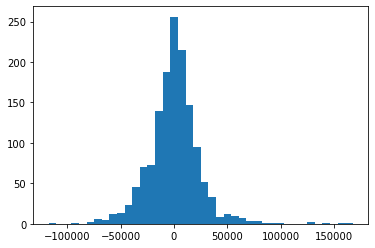

In [21]:
plt.hist(resids, bins = 40);

The distribution of the residuals looks normal, as desired.

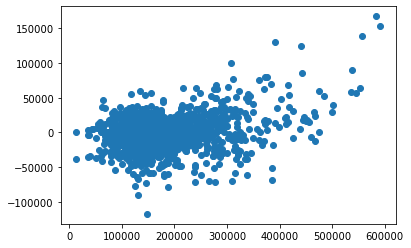

In [22]:
plt.scatter(y_train, resids);

Most of predictions are centered around `y = 0`. Our y-values vs residuals plot does show some slight dispersion towards the top right of the plot. This is not ideal, but it is relatively minor and just shows us that there is likely more data we can incorporate to get more accurate inferences. Still, many of the conditions for inference are met.

---

## Conclusion

#### Prediction

Our goal was to build a linear regression model that accurately can predict the sale prices of homes in Ames, Iowa. Our metric for success was if our model exceeded an R squared score of 75%. Such a model would account for 75% of the variability in the sale price values.

Our production model above achieved an R squared value of 87.9% on unseen data. This demonstrates that it produces fairly reliable price predictions and can be pushed to the public.

Since this is one of the primary features Zillow offers, having stronger performing predictions is extremely relevant to our brand and credibility. Since our revenue stems from advertisement purchases, better public perception is directly related to the company's profitability.

#### Inference 

Beyond predicting home prices, our model also provides insight to how these different features influence the price of the home.

Before we say more her is the list of the features used in our model:
- square feet in the first and second floor
- basement square feet (unfinished basement are counted at half size)
- year the home was built
- neighborhood of the home
- number of finished stories in the home
- the quality of the kitchen (rated 1 through 5)
- the quality and condition of the home (rated 1 through 100)
- the exterior quality and condition of the home (rated 1 through 25)

One major take-away from our model is illustrated below. The list below shows how the price of a 1.5-story home (with a finished second floor) in different neighborhoods compare to Bloomington Heights. Of course this also allows you compare prices between the different neighborhoods outside of Bloomington Heights, too.

In [23]:
# sorted neighborhood coefficients
coef[coef.index.str.contains('neighborhood')].sort_values(ascending = False)

neighborhood_GrnHill    82623.685013
neighborhood_StoneBr    41322.635877
neighborhood_Veenker    27030.921794
neighborhood_NoRidge    21249.939670
neighborhood_NridgHt    18848.161283
neighborhood_Somerst    10805.486752
neighborhood_Crawfor     8042.970961
neighborhood_Timber      7886.609169
neighborhood_Gilbert     5868.001220
neighborhood_ClearCr     3886.622152
neighborhood_CollgCr     2751.021488
neighborhood_SawyerW    -3711.631832
neighborhood_Mitchel    -9249.537279
neighborhood_Landmrk   -11170.305783
neighborhood_Blueste   -12267.769854
neighborhood_NWAmes    -13529.218648
neighborhood_Sawyer    -14872.170088
neighborhood_NPkVill   -14928.605528
neighborhood_NAmes     -16464.138018
neighborhood_BrDale    -16796.029411
neighborhood_Greens    -19130.412225
neighborhood_SWISU     -19836.412560
neighborhood_Edwards   -20379.915196
neighborhood_BrkSide   -20652.107929
neighborhood_MeadowV   -26773.320350
neighborhood_IDOTRR    -28981.896618
neighborhood_OldTown   -34586.642735
d

In [24]:
# for readme
nb_series = coef[coef.index.str.contains('neighborhood')].sort_values(ascending = False)
for nb in nb_series.index:
    print(f'- {nb[13:]}: {round(nb_series[nb],2)}')

- GrnHill: 82623.69
- StoneBr: 41322.64
- Veenker: 27030.92
- NoRidge: 21249.94
- NridgHt: 18848.16
- Somerst: 10805.49
- Crawfor: 8042.97
- Timber: 7886.61
- Gilbert: 5868.0
- ClearCr: 3886.62
- CollgCr: 2751.02
- SawyerW: -3711.63
- Mitchel: -9249.54
- Landmrk: -11170.31
- Blueste: -12267.77
- NWAmes: -13529.22
- Sawyer: -14872.17
- NPkVill: -14928.61
- NAmes: -16464.14
- BrDale: -16796.03
- Greens: -19130.41
- SWISU: -19836.41
- Edwards: -20379.92
- BrkSide: -20652.11
- MeadowV: -26773.32
- IDOTRR: -28981.9
- OldTown: -34586.64


For example, from this list we can see that the least expensive neighborhoods Edwards, Brookside, Meadow Villag, Old Town (Excluding Iowa Department of Transportation and Railroad (IDOTRR)). This kind of information may be of interest to the public and it may be worthwhile to share on our website. This way people will have even more reasons to visit our site, increasing the value in creating ads on our site.

#### Next Steps

Our model is definitely has potential to generate stronger predictions. Also our y-value vs residuals plot show that there may be some minor sale price patterns in our data that we have not entirely captured into our model. These improvements would likely be fairly small and require a lot of time to gain with the current dataset.

If there is interest pursuing stronger predictions still, the main recommendations I would make would be to consider incorporating categorical features that I ruled out because they were quite homogenous (more than 75% of the values were identical). Some of these features may do a good job at predicting the highest value homes which is where the model seems to perform the weakest according to the residuals scatterplot.

Another option would be to look back through data I ruled out before beginning the project. The original dataset includes 80 features, and after some light exploratory data analysis performed outside of these notebooks, I settled on starting with 32 variables.